In [35]:
import pandas as pd

from matplotlib import pyplot as plt
from math import exp, log
from matplotlib.colors import ListedColormap
import numpy as np
import copy
from dtree import DT

In [12]:
FILE = "chips"
ITERATIONS = 100
RESOLUTION = 90

In [3]:
class Dataset:
    def __init__(self, dataset):
        self.features = dataset[:, :-1]
        self.targets = [1 if x == 'P' else -1 for x in dataset[:, 2]]
        self.amount = len(self.targets)

In [9]:
# Чертит график
def draw_plot(quality):
    plt.close()
    steps = [x[0] for x in quality]
    accuracy = [x[1] for x in quality]
    plt.xlabel("Ada step")
    plt.ylabel("Accuracy")
    plt.xscale("log")
    plt.grid(True)
    plt.plot(steps, accuracy, 'r')
    plt.show()

In [13]:
class Divid:
    def __init__(self, dataset, resolution,):
        x_min, y_min = np.amin(dataset.features, 0)
        x_max, y_max = np.amax(dataset.features, 0)
        x_step, y_step = (x_max - x_min) / RESOLUTION, (y_max - y_min) / resolution
        self.x_min, self.x_max = x_min - 3 * x_step, x_max + 3 * x_step
        self.y_min, self.y_max = y_min - 3 * y_step, y_max + 3 * y_step
        self.x_cell, self.y_cell = np.meshgrid(
            np.arange(self.x_min, self.x_max, x_step),
            np.arange(self.y_min, self.y_max, y_step))
        self.sample_color = ["g" if target == 1 else "b" for target in dataset.targets]
        self.x_values = dataset.features[:, 0]
        self.y_values = dataset.features[:, 1]
        self.scatter_counter = 100

    def divider(self, ada, iteration):
        plt.xlim(self.x_min, self.x_max)
        plt.ylim(self.y_min, self.y_max)
        plt.title("Classification after %s iteration" % iteration)
        mesh_dots = np.c_[self.x_cell.ravel(), self.y_cell.ravel()]
        c = np.apply_along_axis(lambda x: ada.predict([x])[0], 1, mesh_dots)
        c = np.array(c).reshape(self.x_cell.shape)
        plt.pcolormesh(self.x_cell, self.y_cell, c, cmap=ListedColormap(['#9090FF', '#90FF90']), shading='nearest')
        plt.scatter(self.x_values, self.y_values, c=self.sample_color)
        self.scatter_counter += 1
        plt.show()

In [34]:
class AdaBoost:
    def __init__(self, algo_amount, classifier):
        self.algo_amount = algo_amount
        self.classifier = classifier
        self.base_algorithms = [] 

    def boost(self, dataset):
        animator = Divid(dataset, RESOLUTION)
        
        # w_i = 1 / |D|
        weights = np.repeat(1 / dataset.amount, dataset.amount)
        stat = []
        
        # for t = 1 to T do
        for iteration in range(self.algo_amount + 1):
            
            cl = self.classifier
            cl.fit(dataset.features, dataset.targets, weights)
            predictions = cl.predict(dataset.features)
            
            # Nt = Sum_|D|_1 (w_i * [ y_i * h(x_i, a_t) < 0 ])
            loss = np.sum([ weights[i] * (predictions[i] != dataset.targets[i])
                           for i in range(dataset.amount)])
            
            
            #                (   1 - Nt   )
            # b_t = 1/2 * ln( ------------)
            #               (      Nt     )
            alpha = 0.5 * log((1 - loss) / loss, exp(1))
            
            
            # for i=1 to |D| do
            for obj in range(len(dataset.targets)):
                # w_i = w_i * exp (-b_t * h(x_i,a_t))
                weights[obj] *= exp(-alpha * predictions[obj] * dataset.targets[obj])
            
            # Normalize ({w_i}|D|_i=1)
            normalised_factor = np.sum(weights)
            weights = weights / normalised_factor
            
            
            self.base_algorithms.append((alpha, cl))
            
            
            if (iteration + 1) in [1,2,3,5,8,13,21,34,55,89]:
                
                # Предсказание
                samples = len(dataset.features)
                weighted_predictions = np.zeros(samples)
                
                # H_N = Sum (b_t * h(x,a_t))
                for algo in self.base_algorithms:
                    weighted_predictions += algo[0] * algo[1].predict(dataset.features)
                predictions = np.fromiter(map(np.sign, weighted_predictions), dtype=int)
                
                # Оценка качества предсказания
                ok = np.sum([predictions[x] == dataset.targets[x] for x in range(dataset.amount)])
                stat.append((iteration + 1, ok / dataset.amount))
                animator.divider(self, iteration + 1)
                print("Pass " + str(iteration + 1) + " iteration")
        return stat


In [7]:
dataset = Dataset(pd.read_csv(open(FILE + ".csv")).values)
tree=DT(1)

In [25]:
dataset = Dataset(pd.read_csv(open(FILE + ".csv")).values)
tree=DecisionTreeClassifier(max_depth=1)

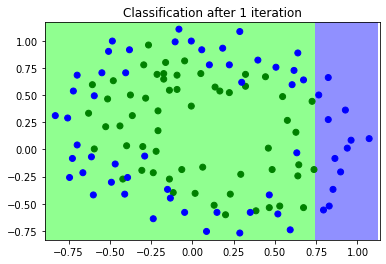

Pass 1 iteration


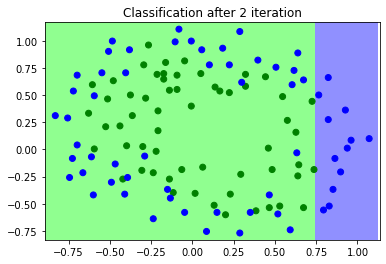

Pass 2 iteration


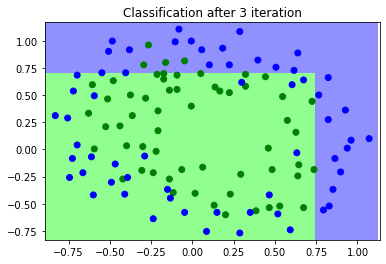

Pass 3 iteration


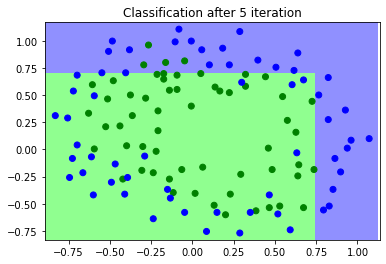

Pass 5 iteration


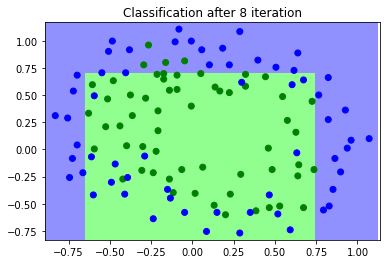

Pass 8 iteration


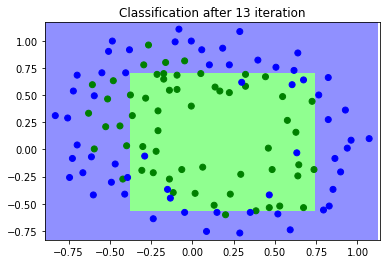

Pass 13 iteration


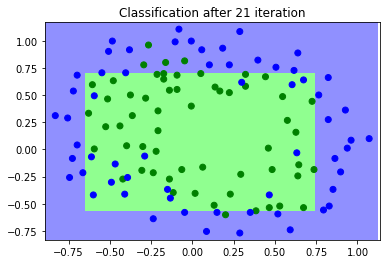

Pass 21 iteration


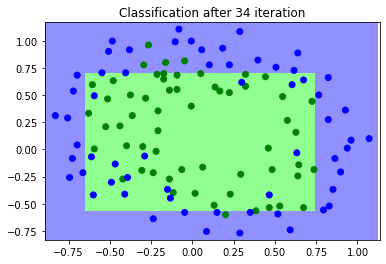

Pass 34 iteration


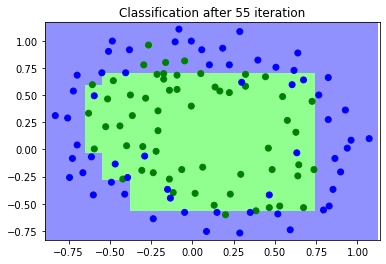

Pass 55 iteration


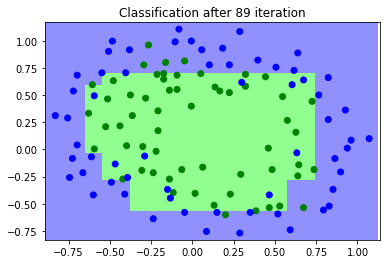

Pass 89 iteration


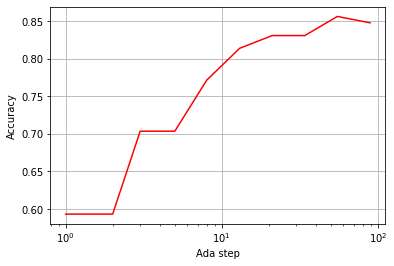

In [142]:
ada = AdaBoost(ITERATIONS, tree)
draw_plot(ada.boost(dataset))